In [1]:
!nvidia-smi

Mon Mar  6 18:09:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Training FasterRCNN using detectron2

In [3]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-q3ne1n4x
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-q3ne1n4x
  Resolved https://github.com/facebookresearch/detectron2.git to commit 778fedc7397ed4cf9f7aa4a7718b87ee1b6b62a9
  Preparing metadata (setup.py) ... done


Now is a good time to confirm that we have the right versions of the libraries at our disposal.

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [5]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

### Load dataset from Roboflow

In [6]:
!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="Yvybg7OmHGRJFqqIIPaG")
project = rf.workspace("university-msm2s").project("graduated-flask-segmentation")
dataset = project.version(2).download("coco")

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Graduated-Flask-segmentation-2 in coco:: 100%|██████████| 520/520 [00:00<00:00, 1515.56it/s]


### Register

When you use Detectron2, before you actually train the model you need to [register it](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset).

In [7]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [8]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME, 
    metadata={}, 
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH, 
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME, 
    metadata={}, 
    json_file=TEST_DATA_SET_ANN_FILE_PATH, 
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME, 
    metadata={}, 
    json_file=VALID_DATA_SET_ANN_FILE_PATH, 
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

We can now confirm that our custom dataset was correctly registered using [MetadataCatalog](https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.MetadataCatalog).

In [9]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['Graduated-Flask-segmentation-train',
 'Graduated-Flask-segmentation-test',
 'Graduated-Flask-segmentation-valid']

### Visualize

Let's take a look at single entry from out train dataset.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



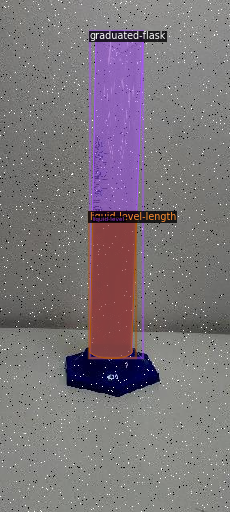

In [10]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata, 
    scale=0.8, 
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

## Train Model Using Custom COCO Format Dataset 

### Configuration

In [11]:
# HYPERPARAMETERS
ARCHITECTURE = "faster_rcnn_X_101_32x8d_FPN_3x"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"
MAX_ITER = 1500
EVAL_PERIOD = 500
BASE_LR = 0.001
NUM_CLASSES = 4  # Num classes + 1

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME, 
    ARCHITECTURE, 
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

### Training

In [13]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/06 18:16:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:18, 23.1MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/06 18:16:41 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)


[03/06 18:17:23 d2.utils.events]:  eta: 0:50:15  iter: 19  total_loss: 3.092  loss_cls: 1.507  loss_box_reg: 0.837  loss_rpn_cls: 0.6385  loss_rpn_loc: 0.1332  time: 2.0356  last_time: 2.0562  data_time: 0.0193  last_data_time: 0.0216   lr: 1.9981e-05  max_mem: 5047M
[03/06 18:18:05 d2.utils.events]:  eta: 0:50:17  iter: 39  total_loss: 2.269  loss_cls: 1.283  loss_box_reg: 0.8725  loss_rpn_cls: 0.04409  loss_rpn_loc: 0.1147  time: 2.0627  last_time: 2.1146  data_time: 0.0131  last_data_time: 0.0202   lr: 3.9961e-05  max_mem: 5047M
[03/06 18:18:48 d2.utils.events]:  eta: 0:50:07  iter: 59  total_loss: 1.878  loss_cls: 0.8716  loss_box_reg: 0.8672  loss_rpn_cls: 0.03177  loss_rpn_loc: 0.08668  time: 2.0875  last_time: 2.1551  data_time: 0.0138  last_data_time: 0.0068   lr: 5.9941e-05  max_mem: 5047M
[03/06 18:19:31 d2.utils.events]:  eta: 0:49:56  iter: 79  total_loss: 1.688  loss_cls: 0.6975  loss_box_reg: 0.893  loss_rpn_cls: 0.01572  loss_rpn_loc: 0.06463  time: 2.1046  last_time: 2.

### Evaluation

In [17]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

[03/06 19:20:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Graduated-Flask-segmentation/faster_rcnn_X_101_32x8d_FPN_3x/2023-03-06-18-16-05/model_final.pth ...


In [18]:
evaluator = COCOEvaluator(TEST_DATA_SET_NAME, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, TEST_DATA_SET_NAME)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [03/06 19:20:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [03/06 19:20:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 19:20:37 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/Graduated-Flask-segmentation-2/test/_annotations.coco.json
[03/06 19:20:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/06 19:20:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/06 19:20:37 d2.data.common]: Serializing 23 elements to byte tensors and concatenating them all ...
[03/06 19:20:37 d2.data.common]: Serialized dataset takes 0.04 MiB
[03/06 19:20:37 d2.evaluation.evaluator]: Start inference on 23 batches
[03/06 

OrderedDict([('bbox',
              {'AP': 80.1646222887326,
               'AP50': 96.74664749083604,
               'AP75': 83.6643809308467,
               'APs': 41.20344177274871,
               'APm': 82.3013587072993,
               'APl': 91.73564043892092,
               'AP-Flask-Segmentation': nan,
               'AP-graduated-flask': 85.7983597395742,
               'AP-liquid-level': 63.91124448983361,
               'AP-liquid-level-length': 90.78426263678999})])

WARNING [03/06 19:12:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 19:12:05 d2.data.datasets.coco]: Loaded 42 images in COCO format from /content/Graduated-Flask-segmentation-2/valid/_annotations.coco.json


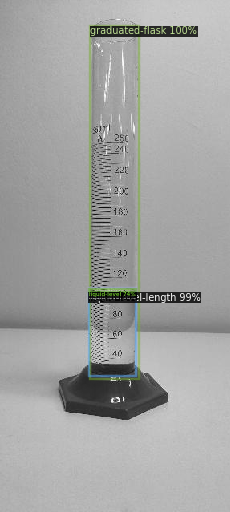

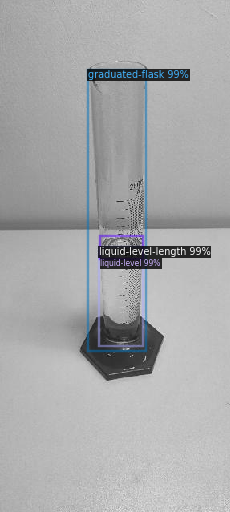

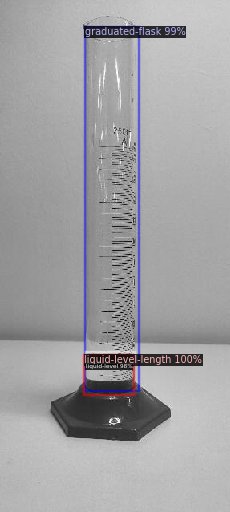

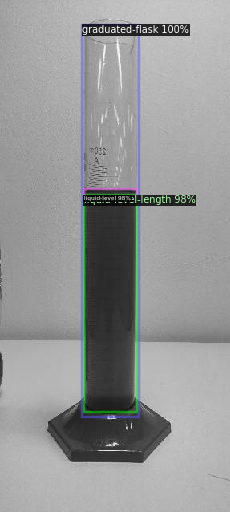

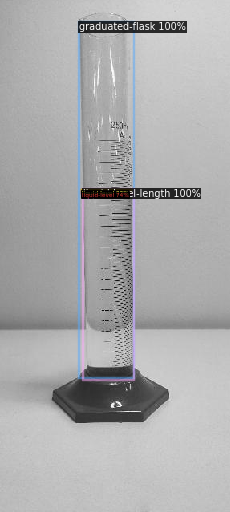

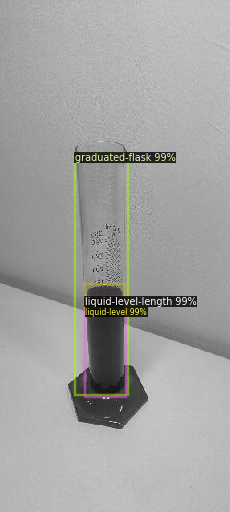

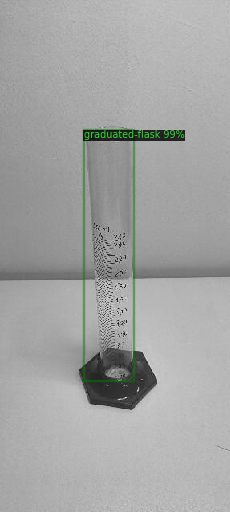

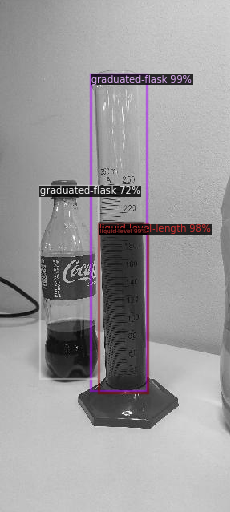

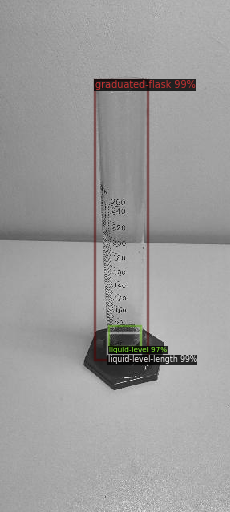

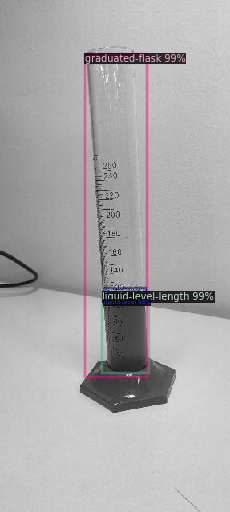

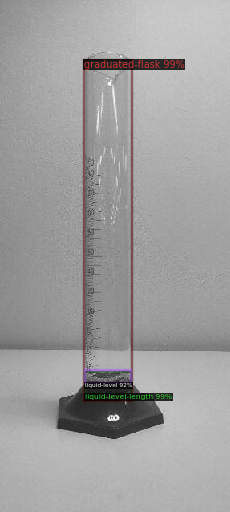

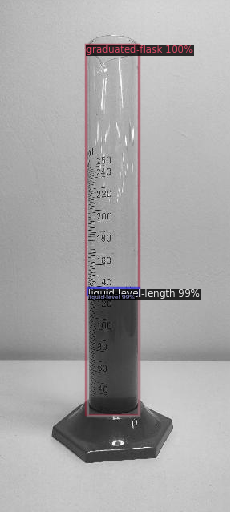

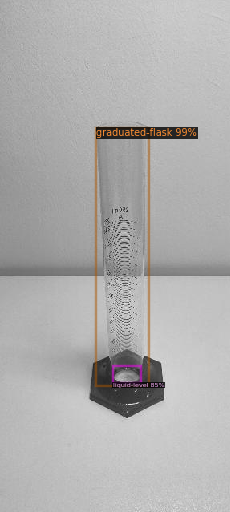

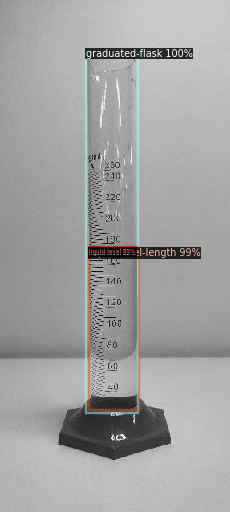

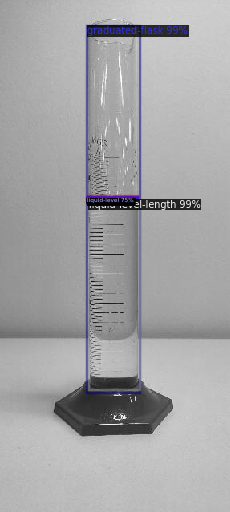

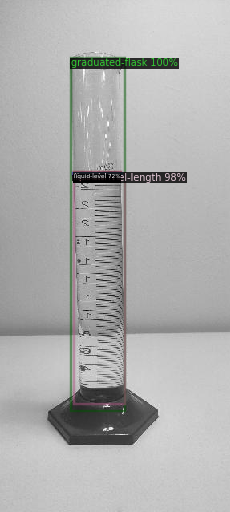

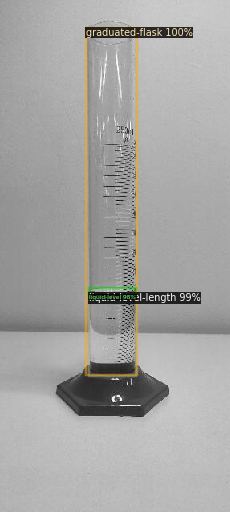

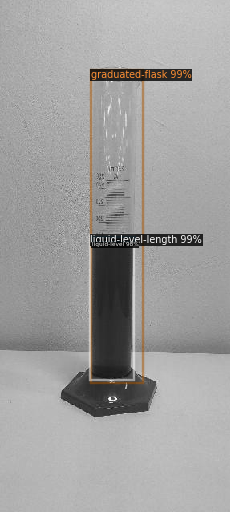

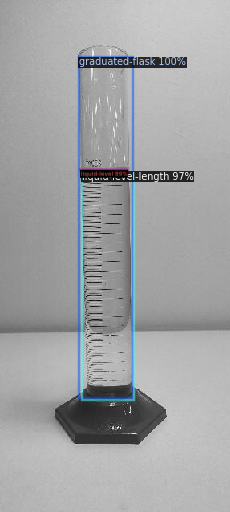

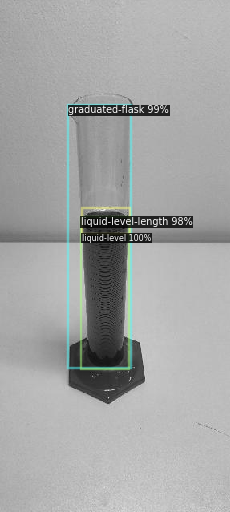

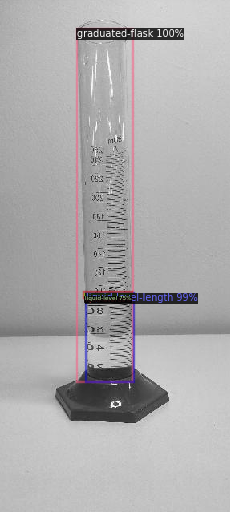

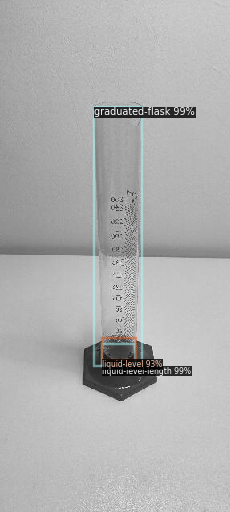

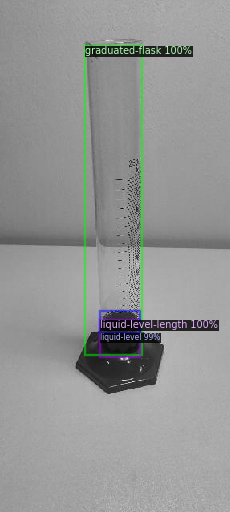

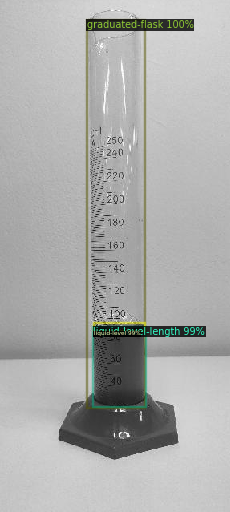

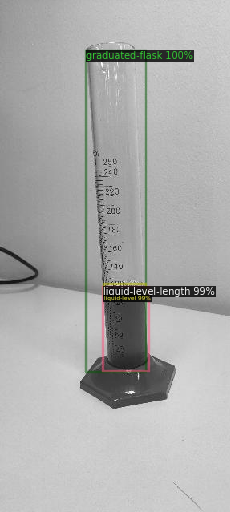

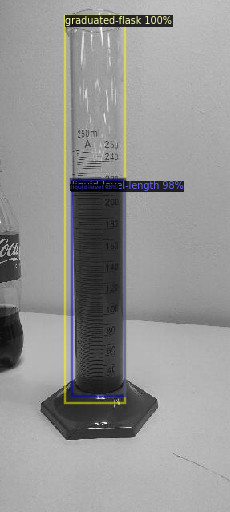

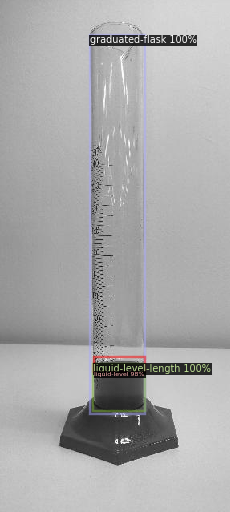

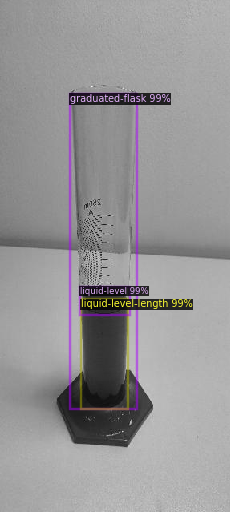

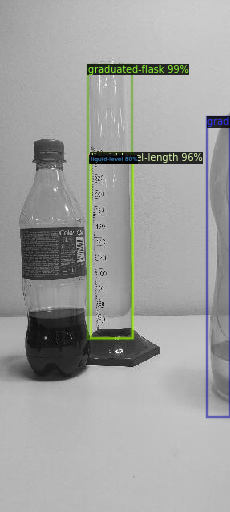

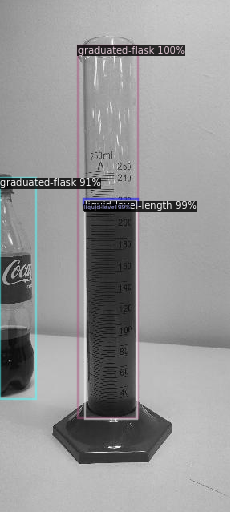

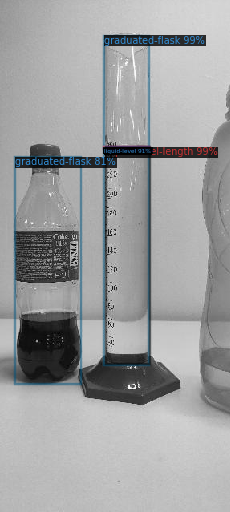

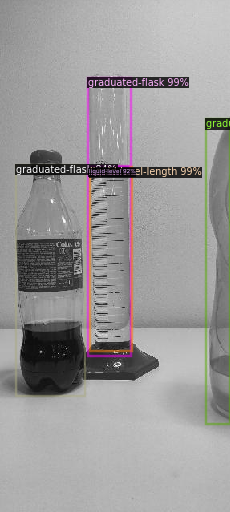

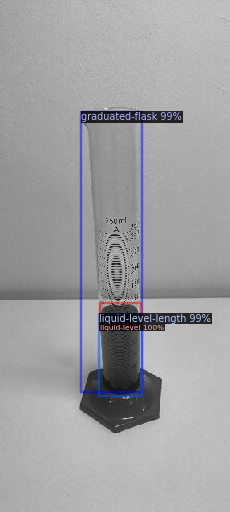

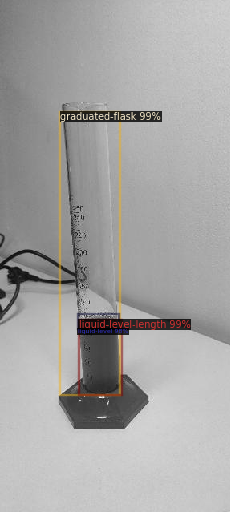

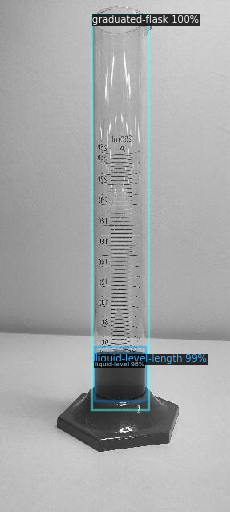

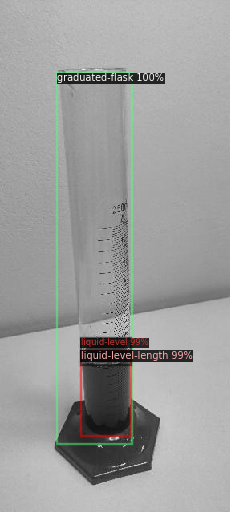

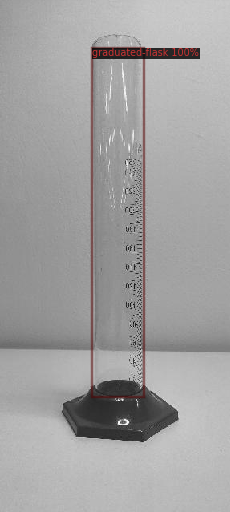

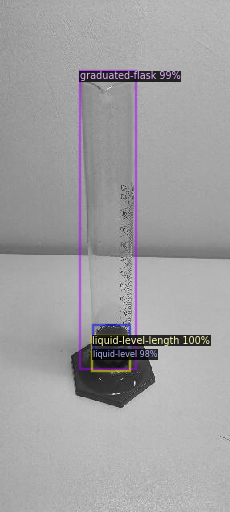

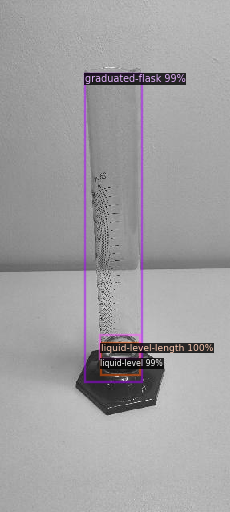

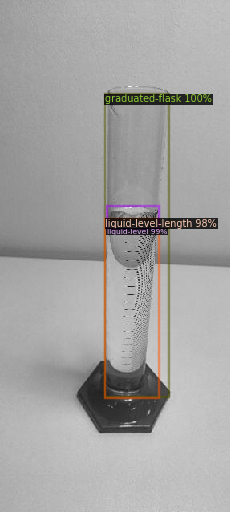

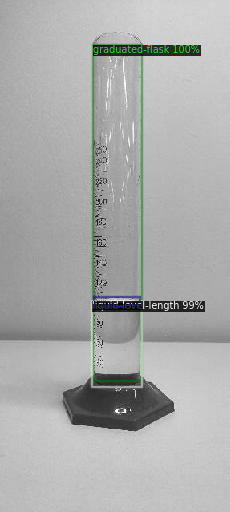

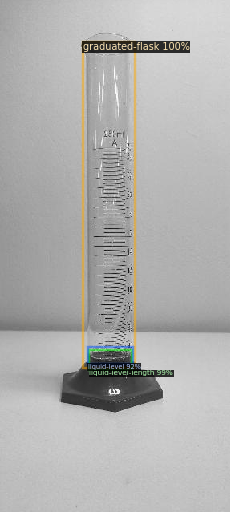

In [16]:
dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata, 
        scale=0.8, 
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [21]:
cd {HOME}/Graduated-Flask-segmentation/faster_rcnn_X_101_32x8d_FPN_3x/2023-03-06-18-16-05
!ls -l --block-size=M

total 797M
-rw-r--r-- 1 root root   1M Mar  6 19:10 events.out.tfevents.1678126581.505b9379ef54.6508.0
-rw-r--r-- 1 root root   1M Mar  6 19:10 last_checkpoint
-rw-r--r-- 1 root root   1M Mar  6 19:10 metrics.json
-rw-r--r-- 1 root root 797M Mar  6 19:10 model_final.pth
